**Load data**

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

# Cloud type index = 37
# clear = 0
# stratus continental = 1
# stratus maritime = 2
# cumulus continental clean = 3
# cumulus continental polluted = 4
# cumulus maritime = 5
# cirrus = 6
# cirrus + water clouds (mixed) >= 7

USE_MIXED = True
USE_PRESSURE_TEMP = True
USE_SPECIFIC_CLOUDS = True
LOW_VIS_FRAC = True
low_vis_frac = 0.4
low_vis_threshold = 10000 #50000
cloud_types = [0, 6] #0,1,2 ::: 0, 3, 4
noise_level = 0.01 # % of max
dnn_batch_size = 64

TEST_FRACTION = False

if USE_MIXED:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_mixed.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_mixed.dat', 'fog_data2_ir_water.dat']
else:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_water.dat']

target_i = 30 # Visibility index
if USE_PRESSURE_TEMP:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))

# Combine .dat files into one numpy array
data_ir_vis = []
for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset2/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset2/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1] 
data_ir_vis = data_ir_vis.astype(np.float32)

# 19 Data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)

# Cloud type index = 37
if USE_SPECIFIC_CLOUDS:
   data_ir_vis = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]


X = data_ir_vis[:, features_i]
y = data_ir_vis[:,target_i]

noise_std_devs = np.zeros(features_i.shape)

for i, feature_i in enumerate(features_i):
    noise_std = (np.max(data_ir_vis[:,feature_i]) - np.min(data_ir_vis[:,feature_i])) * noise_level # 1% of mean or max??
    noise_std_devs[i] = noise_std

# Scaling features and noise standard deviations
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))


if not TEST_FRACTION:
    # First split: Separate out a test set (5% of the original dataset)
    X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=(1/20))


if LOW_VIS_FRAC:
    if not TEST_FRACTION:
        low_vis_i = np.where(target_scaler.inverse_transform(y_temp) < low_vis_threshold)[0]
        high_vis_i = np.where(target_scaler.inverse_transform(y_temp) >= low_vis_threshold)[0]
    else:
        low_vis_i = np.where(target_scaler.inverse_transform(y_scaled) < low_vis_threshold)[0]
        high_vis_i = np.where(target_scaler.inverse_transform(y_scaled) >= low_vis_threshold)[0]


    n_high_vis = int(len(low_vis_i) / low_vis_frac * (1 - low_vis_frac))
    print(f'real frac: {len(low_vis_i)/len(y_scaled)}')
    if n_high_vis > len(high_vis_i):
        n_high_vis = len(high_vis_i)
        n_low_vis = int(low_vis_frac * n_high_vis)
        r_low_vis_i = np.random.choice(low_vis_i, n_low_vis, replace=False)
        low_vis_i = r_low_vis_i
    print(f'n_low_vis: {len(low_vis_i)}. n_high_vis: {n_high_vis}')
    r_high_vis_i = np.random.choice(high_vis_i, n_high_vis, replace=False)
    if not TEST_FRACTION:
        X_temp = np.vstack([X_temp[low_vis_i], X_temp[r_high_vis_i]])
        y_temp = np.vstack([y_temp[low_vis_i], y_temp[r_high_vis_i]])
    else:
        X_temp = np.vstack([X_scaled[low_vis_i], X_scaled[r_high_vis_i]])
        y_temp = np.vstack([y_scaled[low_vis_i], y_scaled[r_high_vis_i]])


if TEST_FRACTION:
    X_temp, X_test, y_temp, y_test = train_test_split(X_temp, y_temp, test_size=(1/19))
  

# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(1/19))

# Create noisy data
X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)

# Create class labels
y_train_label = np.where(target_scaler.inverse_transform(y_train) < low_vis_threshold, 1, 0)
y_val_label = np.where(target_scaler.inverse_transform(y_val) < low_vis_threshold, 1, 0)
y_test_label = np.where(target_scaler.inverse_transform(y_test) < low_vis_threshold, 1, 0)


# Create training data for DNN that adds noise to batches
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size=dnn_batch_size)
training_data_classes = tf.data.Dataset.from_tensor_slices((X_train, y_train_label)).batch(batch_size=dnn_batch_size)

def noise_map(features, labels):
    noise = tf.random.normal(shape=tf.shape(features))
    noise = noise * noise_stds_scaled
    noisy_features = features + noise
    return noisy_features, labels

training_data = training_data.map(noise_map)
training_data_classes = training_data_classes.map(noise_map)


real frac: 0.07588092142547588
n_low_vis: 22762. n_high_vis: 34143


**Classification models**

FFNN / MLP Classifier

Epoch 1/50


/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1710249919.665714 1197187 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710249923.160874 1197182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 - 9s - 64ms/step - accuracy: 0.6752 - loss: 0.7379 - val_accuracy: 0.7316 - val_loss: 0.6278
Epoch 2/50
135/135 - 1s - 4ms/step - accuracy: 0.7447 - loss: 0.5836 - val_accuracy: 0.7639 - val_loss: 0.5441
Epoch 3/50
135/135 - 1s - 5ms/step - accuracy: 0.7765 - loss: 0.5130 - val_accuracy: 0.7980 - val_loss: 0.4910
Epoch 4/50
135/135 - 1s - 4ms/step - accuracy: 0.7964 - loss: 0.4698 - val_accuracy: 0.8150 - val_loss: 0.4535
Epoch 5/50
135/135 - 1s - 4ms/step - accuracy: 0.8123 - loss: 0.4392 - val_accuracy: 0.8247 - val_loss: 0.4303
Epoch 6/50
135/135 - 0s - 4ms/step - accuracy: 0.8211 - loss: 0.4207 - val_accuracy: 0.8321 - val_loss: 0.4125
Epoch 7/50
135/135 - 1s - 4ms/step - accuracy: 0.8299 - loss: 0.4036 - val_accuracy: 0.8421 - val_loss: 0.3972
Epoch 8/50
135/135 - 1s - 4ms/step - accuracy: 0.8362 - loss: 0.3929 - val_accuracy: 0.8374 - val_loss: 0.3878
Epoch 9/50
135/135 - 1s - 4ms/step - accuracy: 0.8371 - loss: 0.3856 - val_accuracy: 0.8467 - val_loss: 0.3788
Epoch 10/50

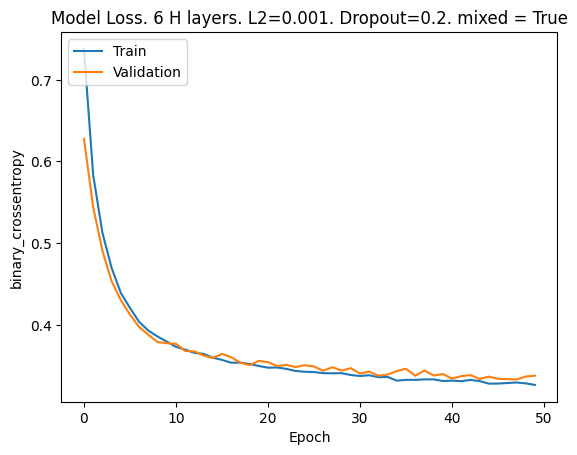

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     13773
           1       0.47      0.76      0.58      1226

    accuracy                           0.91     14999
   macro avg       0.73      0.84      0.77     14999
weighted avg       0.94      0.91      0.92     14999



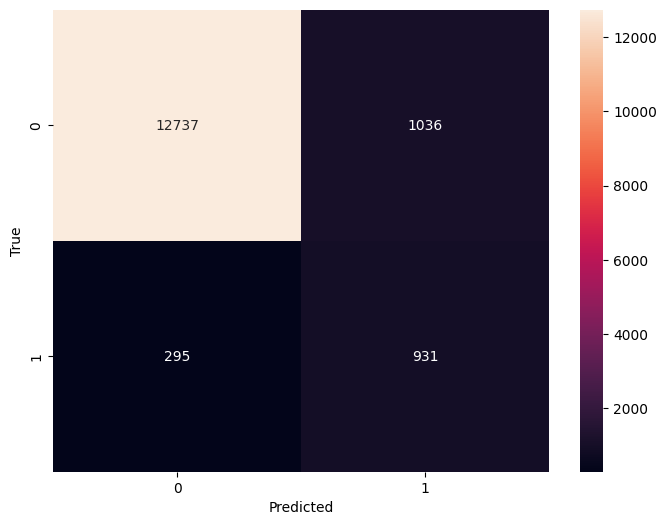

In [16]:
from keras import layers
from keras import regularizers
from keras.layers import Attention
from sklearn.metrics import classification_report


# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),


    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data_classes, epochs = 50, validation_data=(X_val_noisy, y_val_label), verbose=2)


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# for t in thresholds:
#     y_pred_label = (y_pred > t ).astype(int)
#     plt.figure(figsize=(8,6)) 
#     sn.heatmap(confusion_matrix(y_test_label, y_pred_label), annot=True, fmt='d')
#     plt.title(f't = {t}')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()


Random Forest Classifier

/home/edgelab/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.98      0.90      0.94     13773
           1       0.40      0.78      0.53      1226

    accuracy                           0.89     14999
   macro avg       0.69      0.84      0.73     14999
weighted avg       0.93      0.89      0.90     14999



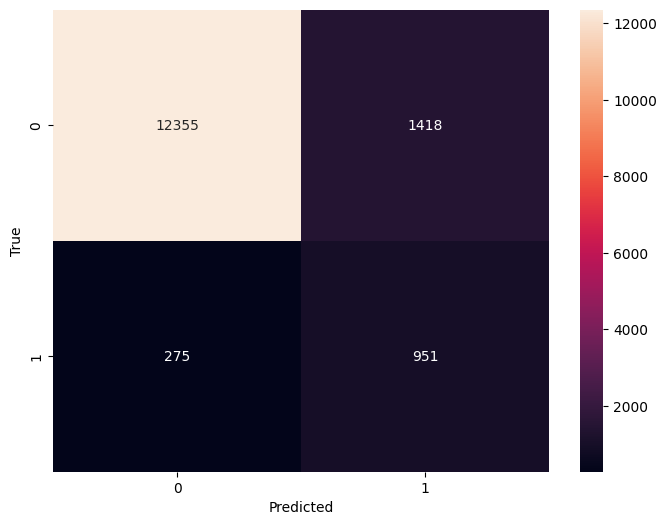

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_noisy, y_train_label)

y_pred_label = rf_model.predict(X_test_noisy)

print(classification_report(y_test_label, y_pred_label))
cm = confusion_matrix(y_test_label, y_pred_label)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Gradient Boosted Classifier

/home/edgelab/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.98      0.87      0.92     13773
           1       0.35      0.78      0.48      1226

    accuracy                           0.86     14999
   macro avg       0.66      0.83      0.70     14999
weighted avg       0.93      0.86      0.89     14999



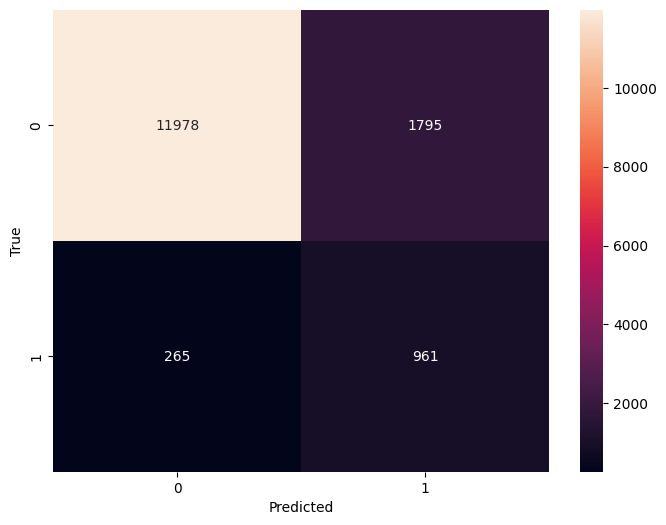

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

rf_model = GradientBoostingClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_noisy, y_train_label)

y_pred_label = rf_model.predict(X_test_noisy)

print(classification_report(y_test_label, y_pred_label))
cm = confusion_matrix(y_test_label, y_pred_label)
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Histograms of target value (visibility)**

All target values

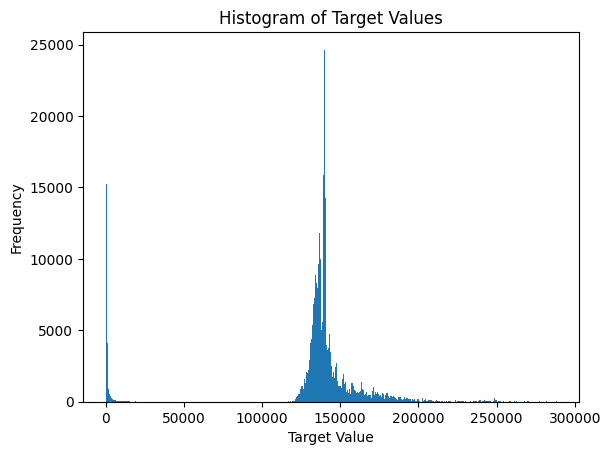

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y, bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

Logarithm of all target values

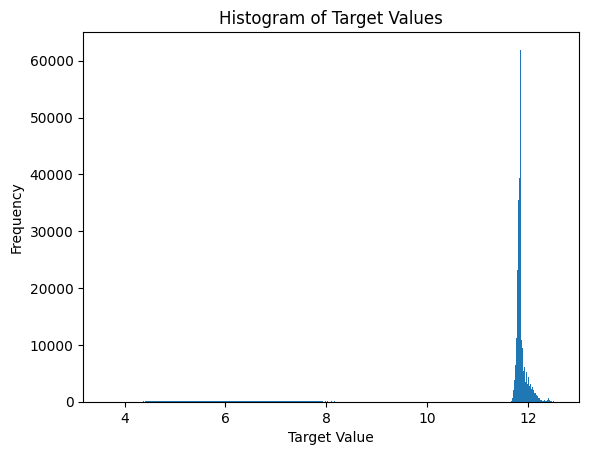

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(np.log(y), bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

"Low visibility" Target values

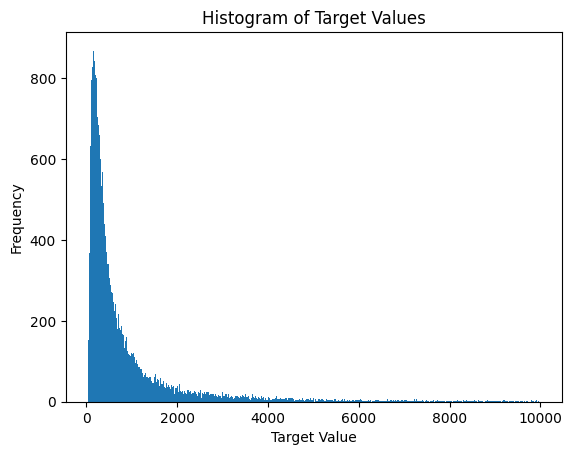

In [21]:
import matplotlib.pyplot as plt
import numpy as np

y_low_vis = y[y < low_vis_threshold]

plt.hist(y_low_vis, bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

Logarithm of "Low visibility" target values

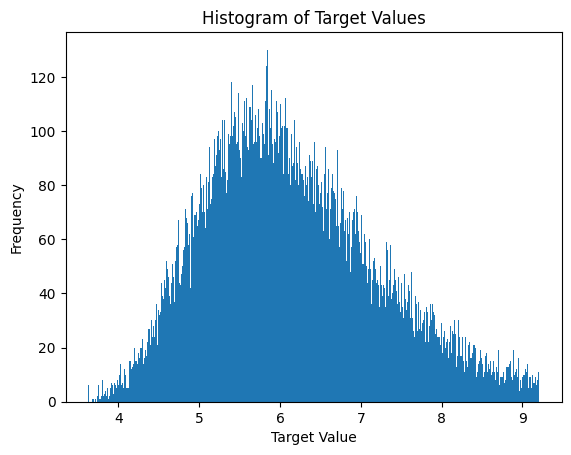

In [22]:
import matplotlib.pyplot as plt
import numpy as np

y_low_vis = y[y < low_vis_threshold]

plt.hist(np.log(y_low_vis), bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

In [12]:
low_vis_i_train = np.where(target_scaler.inverse_transform(y_train) < low_vis_threshold)[0]
X_low_vis_train = X_train_noisy[low_vis_i_train]
y_low_vis_train = np.log(target_scaler.inverse_transform(y_train[low_vis_i_train]))

low_vis_i_val = np.where(target_scaler.inverse_transform(y_val) < low_vis_threshold)[0]
X_low_vis_val = X_val_noisy[low_vis_i_val]
y_low_vis_val = np.log(target_scaler.inverse_transform(y_val[low_vis_i_val]))

low_vis_i_test = np.where(target_scaler.inverse_transform(y_test) < low_vis_threshold)[0]
X_low_vis_test = X_test_noisy[low_vis_i_test]
y_low_vis_test = np.log(target_scaler.inverse_transform(y_test[low_vis_i_test]))

Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_noisy, y_train.ravel())

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test.ravel() - y_pred 

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()


/home/edgelab/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 28.16854382106407


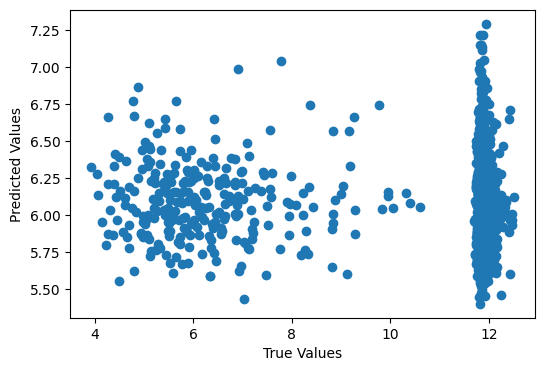

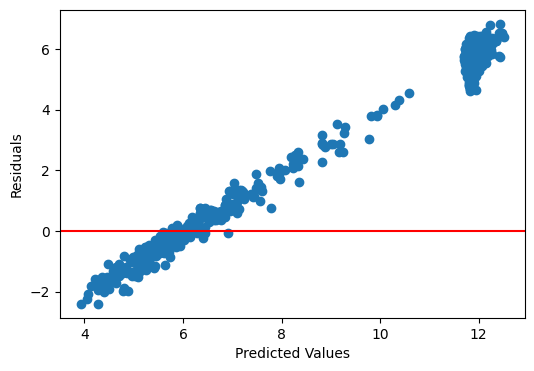

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
#rf_model.fit(X_train_noisy, y_train.ravel())
rf_model.fit(X_low_vis, y_regression)

#y_pred = rf_model.predict(X_test)
y_pred = rf_model.predict(X_low_vis_test)
mse = mean_squared_error(y_regression_test, y_pred)
residuals = y_regression_test.ravel() - y_pred 

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_regression_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_regression_test, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()


Gradient Boosting Regressor

Mean Squared Error: 0.6247968936755467


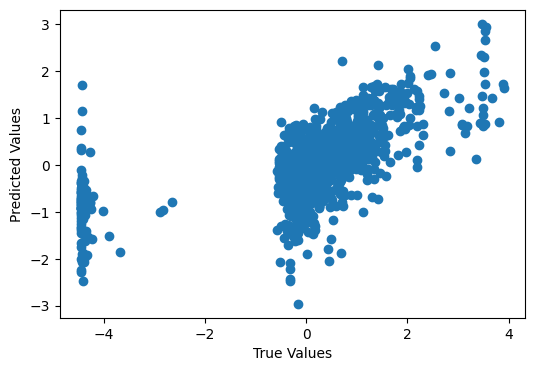

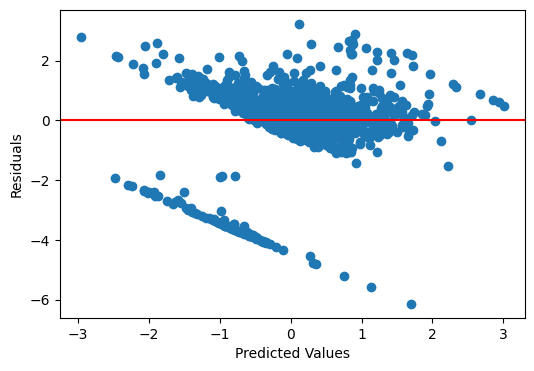

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train.ravel())

y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test.ravel() - y_pred

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

DNN Regression

In [13]:
from keras import layers
from keras import regularizers

# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),

    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.2),
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.2),
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='linear')
])

# Compile the model for regression
ff_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# tf.optimizers.Adam(learning_rate=1e-3)
#model.summary()

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
#history = ff_model.fit(training_data, epochs = 150, validation_data=(X_val_noisy, y_val))
history = ff_model.fit(X_low_vis_train, y_low_vis_train, epochs = 150, validation_data=(X_low_vis_val, y_low_vis_val))


# y_pred = ff_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# residuals = y_test - y_pred 
# print(f'Mean squared error: {mse}')

y_pred = ff_model.predict(X_low_vis_test)
mse = mean_squared_error(y_low_vis_test, y_pred)
residuals = y_test - y_pred 
print(f'Mean squared error: {mse}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

Epoch 1/150


/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-03-07 12:55:29.966164: I external/local_xla/xla/service/service.cc:168] XLA service 0x5596b416ee50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 12:55:29.966195: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-07 12:55:30.001400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-07 12:55:30.289528: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


 70/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.6613 - mean_absolute_error: 3.9772

I0000 00:00:1709816133.365346 1157602 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 11.5962 - mean_absolute_error: 2.6640 - val_loss: 2.4031 - val_mean_absolute_error: 1.1471
Epoch 2/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1564 - mean_absolute_error: 1.1100 - val_loss: 2.1551 - val_mean_absolute_error: 1.0885
Epoch 3/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7631 - mean_absolute_error: 0.9869 - val_loss: 1.8129 - val_mean_absolute_error: 0.9812
Epoch 4/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5932 - mean_absolute_error: 0.9452 - val_loss: 1.7863 - val_mean_absolute_error: 0.9763
Epoch 5/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5147 - mean_absolute_error: 0.9223 - val_loss: 1.4071 - val_mean_absolute_error: 0.8759
Epoch 6/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4693 - mean_absolute_error: 0.9125 - val_loss: 1.4352 - val_mean_absolute_error: 0.8843
Epoch 7/150
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3841 - mean_absolute_error: 0.8792 - val_

ValueError: operands could not be broadcast together with shapes (2500,1) (416,1) 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean squared error: 1.2858693599700928


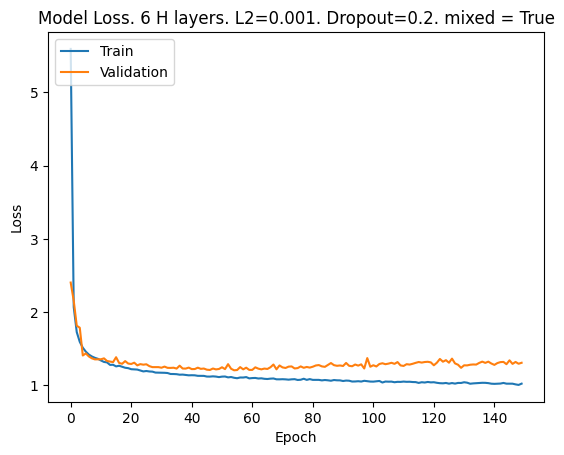

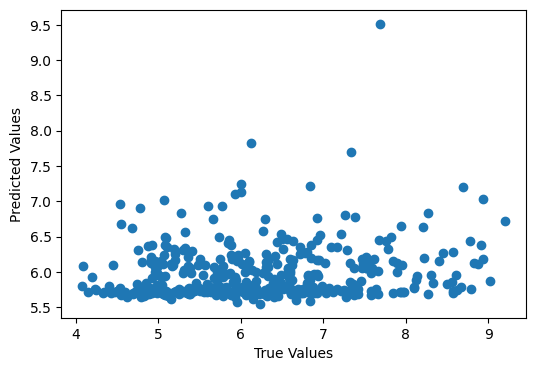

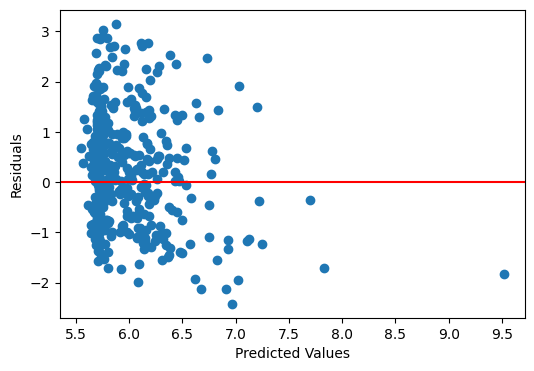

In [14]:
y_pred = ff_model.predict(X_low_vis_test)
mse = mean_squared_error(y_low_vis_test, y_pred)
residuals = y_low_vis_test - y_pred 
print(f'Mean squared error: {mse}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_low_vis_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

Tabnet

/home/edgelab/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73769 | val_0_auc: 0.78765 |  0:00:00s
epoch 1  | loss: 0.48379 | val_0_auc: 0.84316 |  0:00:01s
epoch 2  | loss: 0.44894 | val_0_auc: 0.8545  |  0:00:01s
epoch 3  | loss: 0.42888 | val_0_auc: 0.86877 |  0:00:02s
epoch 4  | loss: 0.41115 | val_0_auc: 0.87171 |  0:00:02s
epoch 5  | loss: 0.39886 | val_0_auc: 0.88586 |  0:00:03s
epoch 6  | loss: 0.39222 | val_0_auc: 0.87935 |  0:00:03s
epoch 7  | loss: 0.38672 | val_0_auc: 0.8826  |  0:00:04s
epoch 8  | loss: 0.38543 | val_0_auc: 0.89496 |  0:00:04s
epoch 9  | loss: 0.37492 | val_0_auc: 0.89691 |  0:00:05s
epoch 10 | loss: 0.36736 | val_0_auc: 0.90099 |  0:00:05s
epoch 11 | loss: 0.36501 | val_0_auc: 0.89947 |  0:00:06s
epoch 12 | loss: 0.36368 | val_0_auc: 0.90034 |  0:00:06s
epoch 13 | loss: 0.3585  | val_0_auc: 0.90241 |  0:00:07s
epoch 14 | loss: 0.35671 | val_0_auc: 0.89732 |  0:00:08s
epoch 15 | loss: 0.35331 | val_0_auc: 0.90791 |  0:00:08s
epoch 16 | loss: 0.3494  | val_0_auc: 0.90893 |  0:00:09s
epoch 17 | los

/home/edgelab/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2103
           1       0.60      0.75      0.67       397

    accuracy                           0.88      2500
   macro avg       0.77      0.83      0.80      2500
weighted avg       0.89      0.88      0.89      2500



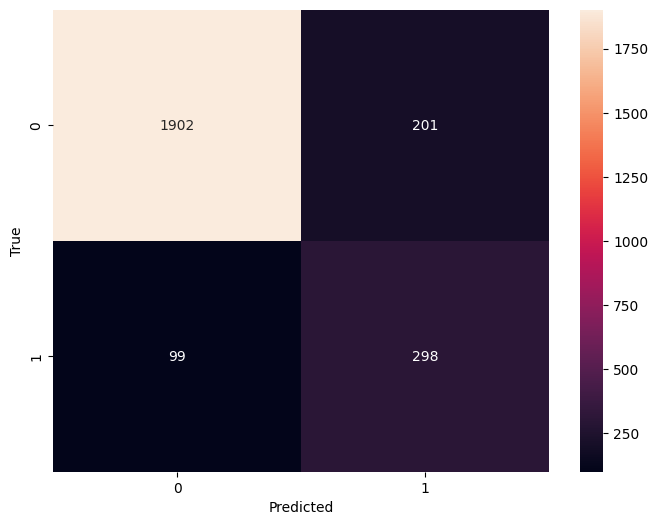

In [84]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

clf = TabNetClassifier()

clf.fit(
  X_train_noisy, y_train_label.ravel(), max_epochs=125,
  eval_set=[(X_val_noisy, y_val_label.ravel())]
)
preds = clf.predict(X_test_noisy)

print(classification_report(y_test_label, preds))
cm = confusion_matrix(y_test_label, preds)

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

DNN Classification with attention

Epoch 1/60


W0000 00:00:1710250305.272313 1197186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710250306.413427 1197180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 - 4s - 29ms/step - accuracy: 0.7051 - loss: 0.6859 - val_accuracy: 0.7382 - val_loss: 0.6114
Epoch 2/60
135/135 - 0s - 4ms/step - accuracy: 0.7719 - loss: 0.5545 - val_accuracy: 0.7750 - val_loss: 0.5505
Epoch 3/60
135/135 - 0s - 4ms/step - accuracy: 0.7966 - loss: 0.5048 - val_accuracy: 0.7940 - val_loss: 0.5068
Epoch 4/60
135/135 - 0s - 4ms/step - accuracy: 0.8119 - loss: 0.4726 - val_accuracy: 0.8130 - val_loss: 0.4810
Epoch 5/60
135/135 - 0s - 3ms/step - accuracy: 0.8254 - loss: 0.4482 - val_accuracy: 0.8197 - val_loss: 0.4567
Epoch 6/60
135/135 - 1s - 4ms/step - accuracy: 0.8321 - loss: 0.4315 - val_accuracy: 0.8287 - val_loss: 0.4435
Epoch 7/60
135/135 - 0s - 4ms/step - accuracy: 0.8378 - loss: 0.4194 - val_accuracy: 0.8314 - val_loss: 0.4304
Epoch 8/60
135/135 - 0s - 4ms/step - accuracy: 0.8421 - loss: 0.4110 - val_accuracy: 0.8351 - val_loss: 0.4238
Epoch 9/60
135/135 - 0s - 3ms/step - accuracy: 0.8449 - loss: 0.4034 - val_accuracy: 0.8327 - val_loss: 0.4177
Epoch 10/60

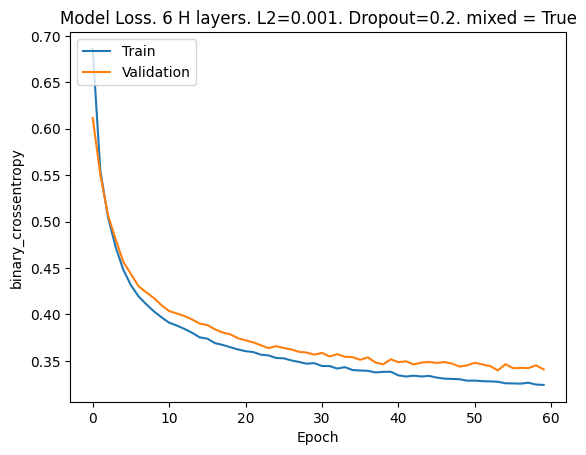

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     13773
           1       0.44      0.83      0.58      1226

    accuracy                           0.90     14999
   macro avg       0.71      0.87      0.76     14999
weighted avg       0.94      0.90      0.91     14999



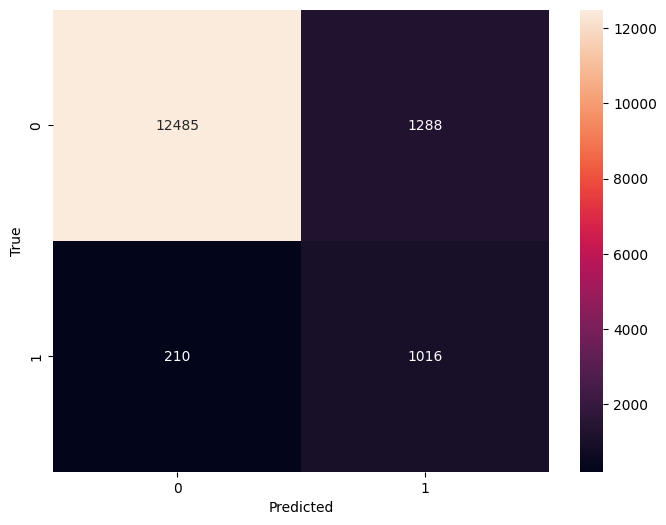

In [24]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Flatten

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)

# Flatten the output of the hidden layer
flatten_layer = Flatten()(hidden_layer_1)

# Reshape to ensure it's 2D
reshaped_layer = layers.Reshape((1, -1))(flatten_layer)

# Attention layer
attention = Attention()([reshaped_layer, reshaped_layer])

# Additional hidden layers
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_2)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history = ff_model.fit(training_data_classes, epochs = 60, validation_data=(X_val_noisy, y_val_label), verbose=2)

y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int).flatten()
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Flatten

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Flatten the output of the input layer
flatten_layer = Flatten()(input_layer)

# Reshape to ensure it's 2D
reshaped_layer = layers.Reshape((1, -1))(flatten_layer)

# Attention layer
attention = Attention()([reshaped_layer, reshaped_layer])

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention)

# Additional hidden layers
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_1)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_2)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(hidden_layer_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

Epoch 1/60


W0000 00:00:1710250372.036359 1197182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710250375.858864 1197182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 - 9s - 66ms/step - accuracy: 0.6843 - loss: 0.7306 - val_accuracy: 0.7275 - val_loss: 0.6436
Epoch 2/60
135/135 - 1s - 4ms/step - accuracy: 0.7324 - loss: 0.6267 - val_accuracy: 0.7546 - val_loss: 0.5799
Epoch 3/60
135/135 - 1s - 5ms/step - accuracy: 0.7582 - loss: 0.5672 - val_accuracy: 0.7836 - val_loss: 0.5245
Epoch 4/60
135/135 - 1s - 4ms/step - accuracy: 0.7816 - loss: 0.5190 - val_accuracy: 0.8080 - val_loss: 0.4818
Epoch 5/60
135/135 - 1s - 4ms/step - accuracy: 0.8006 - loss: 0.4819 - val_accuracy: 0.8207 - val_loss: 0.4479
Epoch 6/60
135/135 - 1s - 4ms/step - accuracy: 0.8141 - loss: 0.4542 - val_accuracy: 0.8357 - val_loss: 0.4206
Epoch 7/60
135/135 - 1s - 4ms/step - accuracy: 0.8216 - loss: 0.4395 - val_accuracy: 0.8354 - val_loss: 0.4115
Epoch 8/60
135/135 - 1s - 4ms/step - accuracy: 0.8258 - loss: 0.4263 - val_accuracy: 0.8414 - val_loss: 0.3972
Epoch 9/60
135/135 - 1s - 4ms/step - accuracy: 0.8304 - loss: 0.4168 - val_accuracy: 0.8407 - val_loss: 0.3957
Epoch 10/60

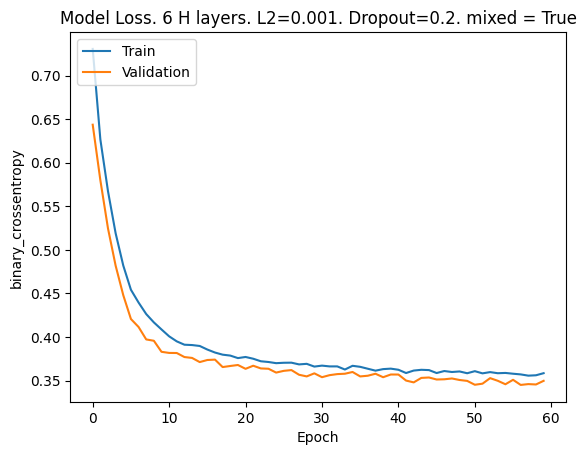

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     13773
           1       0.45      0.81      0.57      1226

    accuracy                           0.90     14999
   macro avg       0.71      0.86      0.76     14999
weighted avg       0.94      0.90      0.91     14999



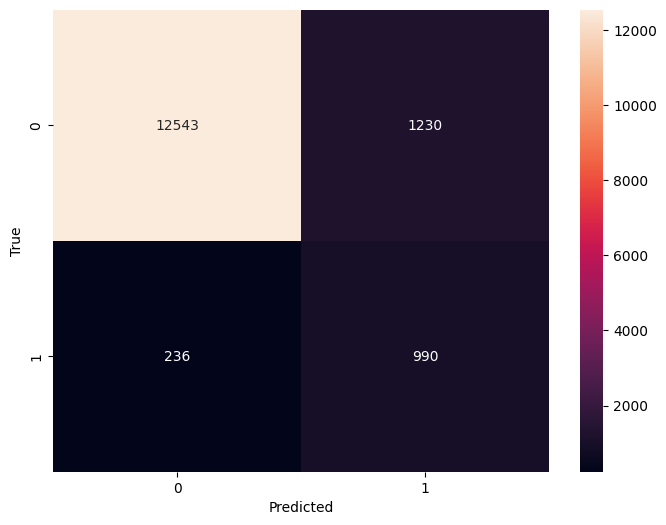

In [26]:
from keras import layers
from keras import regularizers
from keras.layers import Attention, Input, Reshape

# Define the input layer
input_layer = Input(shape=(len(features_i),))

# Reshape input to include a singleton dimension for timestep
reshaped_input = Reshape((1, len(features_i)))(input_layer)

# Attention layer
attention = Attention()([reshaped_input, reshaped_input])

# Flatten the attention output to merge the timestep dimension
flattened_attention = layers.Flatten()(attention)
dropout_0 = layers.Dropout(0)(flattened_attention)


# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_0)
dropout_1 = layers.Dropout(0.2)(hidden_layer_1)
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = layers.Dropout(0.2)(hidden_layer_2)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_2)
dropout_3 = layers.Dropout(0.2)(hidden_layer_3)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

history = ff_model.fit(training_data_classes, epochs = 60, validation_data=(X_val_noisy, y_val_label), verbose=2)


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

DNN for regression with Multi head attention

Epoch 1/60


W0000 00:00:1710250425.297174 1197187 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710250429.631227 1197182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 - 11s - 80ms/step - accuracy: 0.6597 - loss: 0.7124 - val_accuracy: 0.7205 - val_loss: 0.6096
Epoch 2/60
135/135 - 1s - 4ms/step - accuracy: 0.7267 - loss: 0.5799 - val_accuracy: 0.7346 - val_loss: 0.5577
Epoch 3/60
135/135 - 1s - 4ms/step - accuracy: 0.7452 - loss: 0.5395 - val_accuracy: 0.7526 - val_loss: 0.5198
Epoch 4/60
135/135 - 1s - 4ms/step - accuracy: 0.7766 - loss: 0.4883 - val_accuracy: 0.7963 - val_loss: 0.4582
Epoch 5/60
135/135 - 1s - 4ms/step - accuracy: 0.8009 - loss: 0.4545 - val_accuracy: 0.8144 - val_loss: 0.4367
Epoch 6/60
135/135 - 1s - 4ms/step - accuracy: 0.8063 - loss: 0.4400 - val_accuracy: 0.8170 - val_loss: 0.4285
Epoch 7/60
135/135 - 1s - 4ms/step - accuracy: 0.8134 - loss: 0.4285 - val_accuracy: 0.8224 - val_loss: 0.4211
Epoch 8/60
135/135 - 1s - 4ms/step - accuracy: 0.8164 - loss: 0.4231 - val_accuracy: 0.8214 - val_loss: 0.4231
Epoch 9/60
135/135 - 1s - 4ms/step - accuracy: 0.8173 - loss: 0.4200 - val_accuracy: 0.8224 - val_loss: 0.4140
Epoch 10/6

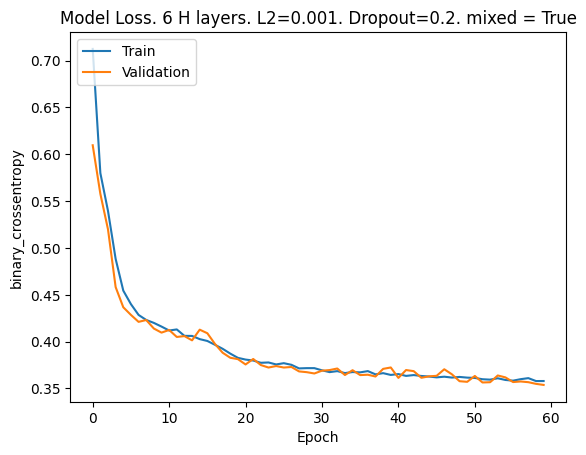

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     13773
           1       0.42      0.79      0.55      1226

    accuracy                           0.89     14999
   macro avg       0.70      0.85      0.74     14999
weighted avg       0.93      0.89      0.91     14999



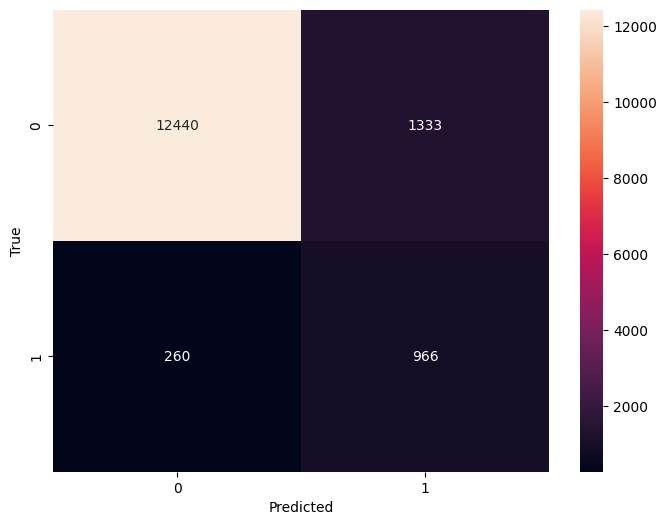

In [27]:
from keras import layers
from keras import regularizers
from keras.layers import MultiHeadAttention, Input, Reshape

input_layer = Input(shape=(len(features_i),))

# Reshape input to include a singleton dimension for timestep
reshaped_input = Reshape((1, len(features_i)))(input_layer)

# Multi-head Attention layer
multi_head_attention = MultiHeadAttention(num_heads=4, key_dim=2)(reshaped_input, reshaped_input)

# Flatten the multi-head attention output to merge the timestep dimension
flattened_attention = layers.Flatten()(multi_head_attention)
#dropout_0 = layers.Dropout(0)(flattened_attention)

# Hidden layers
hidden_layer_1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(flattened_attention)
dropout_1 = layers.Dropout(0.2)(hidden_layer_1)
hidden_layer_2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = layers.Dropout(0.2)(hidden_layer_2)
hidden_layer_3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_2)
dropout_3 = layers.Dropout(0.2)(hidden_layer_3)
hidden_layer_4 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_3)

# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(hidden_layer_4)

# Define the model
ff_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

history = ff_model.fit(training_data_classes, epochs=60, validation_data=(X_val_noisy, y_val_label), verbose=2)

y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)

from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


QRNN (not working)

In [ ]:
import keras
import quantnn as q

quantiles=[0.1, 0.5, 0.9]
layers = 4
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = q.QRNN(quantiles, n_inputs=1, model=model)
training_data = (X_train, y_train)
# Model setup
model = qrnn(quantiles=[0.1, 0.5, 0.9], n_inputs=len(features_i))  # Estimate 10th, 50th, 90th percentiles
results = qrnn.train(training_data=training_data, n_epochs=15)

# Model fitting
model.train(X_train, y_train, epochs=100)

# Predictions
predictions = model.predict(X_test) 
print(predictions)

In [ ]:
from typhon.retrieval.qrnn.qrnn import QRNN

# 2. Create QRNN Model (Same as before)
model = QRNN(
    quantiles=[0.1, 0.5, 0.9],  
    input_dimensions=X_train.shape[1],
    model=(3, 128, 'relu'),
    initial_learning_rate = 0.01
)

training_data = (X_train, y_train)
validation_data = (X_val, y_val)

# 3. Train the Model (Updated)
model.train(training_data, validation_data, batch_size=32) 